<a href="https://colab.research.google.com/github/MaxRSilva/Python-Analise_de_dados_com_SQL/blob/main/Notebook_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [712]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [713]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [714]:
Itens_pedidos = pd.read_csv(url_itens_pedidos)
Pedidos =  pd.read_csv(url_pedidos)
Produtos = pd.read_csv(url_produto)
Vendedores = pd.read_csv(url_vendedores)


In [715]:
engine = create_engine('sqlite:///:memory:')

In [716]:
Itens_pedidos.to_sql('Itens_pedidos', engine, index=False)

24527

In [717]:
Pedidos.to_sql('Pedidos', engine, index=False)

24527

In [718]:
Produtos.to_sql('Produtos', engine, index=False)

205

In [719]:
Vendedores.to_sql('Vendedores', engine, index=False)

5

In [720]:
Inspector = inspect (engine)
display(Inspector.get_table_names())

['Itens_pedidos', 'Pedidos', 'Produtos', 'Vendedores']

# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [721]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [722]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [723]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [724]:
query = '''SELECT
              CONDICAO,
              COUNT(*) as 'Quantidade'
            FROM PRODUTOS
            GROUP BY CONDICAO''';
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


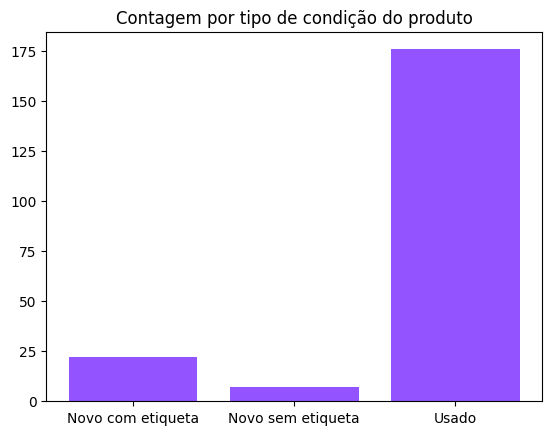

In [725]:
plt.bar(df_produtos["Condicao"],df_produtos['Quantidade'], color = '#9353FF')
plt.title ('Contagem por tipo de condição do produto')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [726]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [727]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [728]:
query =  '''SELECT
            ITENS_PEDIDOS.produto_id,
            PRODUTOS.produto,
            SUM (ITENS_PEDIDOS.quantidade) as 'Soma_dos_Produtos'
          FROM ITENS_PEDIDOS
          JOIN PRODUTOS
              ON PRODUTOS.produto_id = ITENS_PEDIDOS.produto_id
          GROUP BY PRODUTOS.produto
          ORDER BY Soma_dos_Produtos ASC'''
df_prod_quant = sql_df(query)
df_prod_quant

,produto_id,produto,Soma_dos_Produtos
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,11218,Calca Alfaiataria Preta,750
198,72667,Saia Pregas Preta,751
199,98640,Calca Jeans Costuras,755


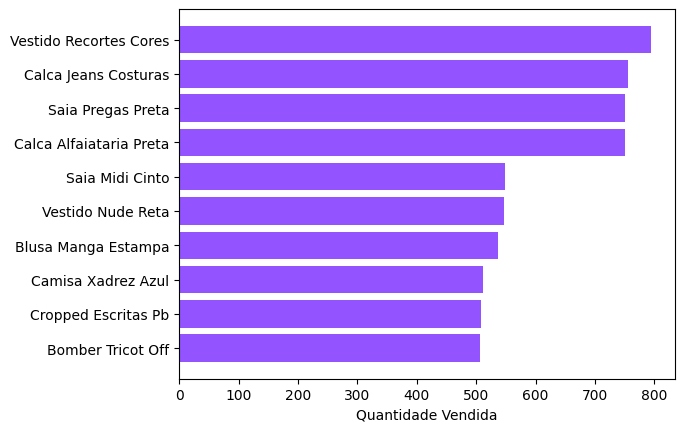

In [729]:
plt.barh(df_prod_quant['produto'][-10:],df_prod_quant['Soma_dos_Produtos'][-10:], color='#9353FF')
plt.xlabel('Quantidade Vendida')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.